# MXNet实现线性回归模型

In [36]:
import numpy as np
import mxnet as mx
from mxnet import nd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from mxnet import autograd

人工生成训练数据，批量样本特征 $X\in\mathbb{R}^{1000*2}$,使用线性回归模型真实权重$\omega=[2,-3.4]^T$和偏差$b=4.2$,以及一个随机噪声$\epsilon$来生成标签

$$y=X\omega+b+\epsilon$$
其中噪音项$\epsilon$服从均值为0，标准差为0.01的正态分布。

In [37]:
num_inputs = 2
num_examples=1000
true_w = [2,-3.4]
true_b = 4.2
GTX_1050Ti = mx.gpu()
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs),ctx=mx.gpu())
labels = true_w[0]*features[:,0]+true_w[1]*features[:,1]+true_b
labels += nd.random.normal(scale=0.01,shape=labels.shape,ctx=mx.gpu())

## 绘制该模型的散点图

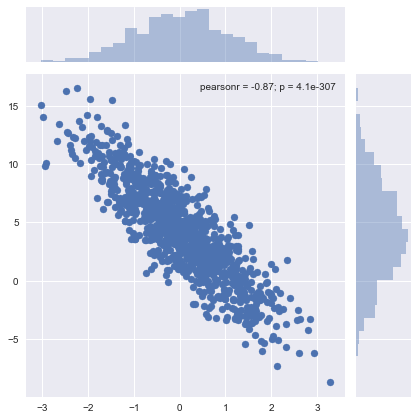

In [38]:
sns.set(color_codes=True)

sns.jointplot(features[:,1].asnumpy(),labels.asnumpy())


##  读取数据，每次返回batch_size个随机样本的特征以及标签


In [45]:
def next_batch(batch_size,features,labels):
    
    num_examples = len(features)
    #随机打乱顺序
    indices = list(range(num_examples))
    random.shuffle(indices)
    with GTX_1050Ti:
        #循环取数据
        for i in range(0,num_examples,batch_size):
            j = nd.array(indices[i:min(i+batch_size,num_examples)])
            yield features.take(j),labels.take(j)

In [47]:
batch_size = 10

for X,y in next_batch(batch_size,features,labels):
    print(X,y)
    break


[[ 1.8560637  -0.1826337 ]
 [ 0.27158523 -0.349416  ]
 [ 2.0639064   0.61349773]
 [-0.20518251  0.9330698 ]
 [ 0.55356747  2.2655048 ]
 [-0.6884633  -1.6836799 ]
 [ 0.54133976 -0.56768125]
 [-1.1085693  -0.48454237]
 [-0.8884967   0.01321069]
 [ 1.1023754   0.83072424]]
<NDArray 10x2 @gpu(0)> 
[ 8.519206   5.9235325  6.243045   0.6189215 -2.3776455  8.545671
  7.2150292  3.628638   2.3868089  3.5711946]
<NDArray 10 @gpu(0)>


## 初始化权重模型的参数

In [52]:
with GTX_1050Ti:
    w = nd.random.normal(scale=0.01,shape=(num_inputs,1))
    b= nd.zeros(shape=(1,))

## 创建需要学习参数的梯度

In [53]:
w.attach_grad()
b.attach_grad()

## 定义模型，用矩阵乘法做

In [54]:
def linreg(X,w,b):
    return nd.dot(X,w)+b

## 定义损失函数

In [61]:
def squared_loss(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    return (y_hat-y.reshape(y_hat.shape))**2/2

## 定义优化算法
小批量随机梯度下降

$\theta_{t+1}=\theta_{t}-\eta*g$ 

$g$表示当前梯度

这里自动求梯度模块计算得来的是梯度是一个批量样本的梯度和，所以梯度需要除以batch_size

In [56]:
def sgd(params,lr,batch_size):
    
    for param in params:
        param[:] = param-lr*param.grad/batch_size

##  训练模型
对模型进行多次迭代参数。每次迭代中，我们根据当前读取的小批量样本数据，通过反复调用反向backward计算小批量随机梯度，并用sgd更新参数

具体步骤如下：
    
+ 使用next_batch取出小批量的数据
+ 使用模型net进行前向运算，并且使用loss计算本次的损失函数值,要用 record函数记录去梯度过程的计算
+ 误差反向传递bp，用backward函数求取梯度
+ 使用sgd迭代优化参数的值
+ 继续进行进行下一次迭代



In [62]:
lr =0.03
num_epochs =3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in next_batch(batch_size,features,labels):
        with autograd.record():
            l = loss(net(X,w,b),y)   #l 是有关小批量X和y的损失
        l.backward()                 #小批量的损失对模型参数求梯度
        sgd([w,b],lr,batch_size)     #使用小批量随机梯度下降迭代模型的参数
    train_l = loss(net(features,w,b),labels)
    print('epoch %d,loss %f'%(epoch+1,train_l.mean().asnumpy()))

(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1)
(10,)
(10, 1

## 训练完毕，查看训练完成的模型参数

In [60]:
w,b

(
 [[ 2.0003974]
  [-3.399998 ]]
 <NDArray 2x1 @gpu(0)>, 
 [4.1994042]
 <NDArray 1 @gpu(0)>)